In [16]:
# GPS Algorithm Code 실행 방법
# 1. Anaconda 가상환경 새로 만들기 (conda create -n <환경이름> python=3.8.5)
# 2. conda activate <환경이름>
# 3. (환경이름) >> conda install matplotlib=3.3.2 pandas=1.2.4 numpy=1.19.2 jupyter
# 4. (환경이름) >> conda install -c conda-forge haversine
# 5. (환경이름) >> conda install -c conda-forge folium
# 6. >> jupyter notebook

In [17]:
# 전역 변수 설정
FILE_SAVE_DIR = './' #있다면 추가 해주기 (상대경로)
line_color_list = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
                    'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white',
                    'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray'] 

In [18]:
import pandas as pd
import numpy as np
from csv import reader
from numpy import linalg as la
from sys import exit
from haversine import haversine
import math
from operator import itemgetter

#시각화 도구
import folium
from folium.features import DivIcon
import random
import matplotlib.pyplot as plt

In [29]:
#Call CSV file
def load_GPS_set(UID): # Data load
    try:
        data_set = pd.read_csv(FILE_SAVE_DIR + UID +"_gps"+".csv", sep=",", dtype='unicode')
        data_set['TIME STAMP'] = pd.to_datetime(data_set['LOG TIME'])
        # data_set['TIME'] = data_set['TIME STAMP'].dt.strftime('%Y-%m-%d %H:%M') # 초단위 자르기
        # data_set['STAMP_TIME'] = pd.to_datetime(data_set['TIME']) # stamp_time datetime 형식으로 변경
        re_data_set = data_set[["TIME STAMP","UID","altitude","latitude","longitude","provider"]]
        return re_data_set
    
    except FileNotFoundError as e:
        pass
def load_Sateillate_set(UID): # Data load
    try:
        data_set = pd.read_csv(FILE_SAVE_DIR + UID +"_sate"+".csv", sep=",", dtype='unicode')
        data_set['TIME STAMP'] = pd.to_datetime(data_set['LOG TIME'])
        # data_set['TIME'] = data_set['TIME STAMP'].dt.strftime('%Y-%m-%d %H:%M') # 초단위 자르기
        # data_set['STAMP_TIME'] = pd.to_datetime(data_set['TIME']) # stamp_time datetime 형식으로 변경
        re_data_set = data_set[["TIME STAMP","UID","SNR AVERAGE","SATELLITE COUNT"]]
        return re_data_set
    
    except FileNotFoundError as e:
        pass

def merge_gps_sati_set(UID): # for weight_filter
    merge_df = pd.merge(load_GPS_set(UID),load_Sateillate_set(UID), how='left', on = ['TIME STAMP','UID'])
    return merge_df

test ='2DDB3706DE4F7B45'
Nicname = '5CAC8432AE4EC54B'
Huzzi = '44754E5A077F32B4'
oizi = '2DDB3706DE4F7B45'

PATIENT_UID = Nicname # 감염자 UID

# TARGET_UID =  # 조사 대상자 UID

# Nicname_df = merge_gps_sati_set(Nicname)
Huzzi_df = merge_gps_sati_set(Huzzi)
oizi_df = merge_gps_sati_set(oizi)
oizi_df

,TIME STAMP,UID,altitude,latitude,longitude,provider,SNR AVERAGE,SATELLITE COUNT
0,2022-02-21 17:07:30,2DDB3706DE4F7B45,62.60000228881836,37.5507354,127.0753583,network,27.0667,3
1,2022-02-21 17:07:25,2DDB3706DE4F7B45,7.3,37.550713333333334,127.07536,gps,26.2714,7
2,2022-02-21 17:07:20,2DDB3706DE4F7B45,62.60000228881836,37.5507417,127.0753425,network,26.26,5
3,2022-02-21 17:07:15,2DDB3706DE4F7B45,7.3,37.550713333333334,127.07536666666668,gps,25.0571,7
4,2022-02-21 17:07:10,2DDB3706DE4F7B45,62.60000228881836,37.5507551,127.0753467,network,27.625,4
...,...,...,...,...,...,...,...,...
8739,2021-09-06 11:22:18,2DDB3706DE4F7B45,67.9000015258789,37.5507132,127.07543,network,0.0,0
8740,2021-09-06 11:21:18,2DDB3706DE4F7B45,67.9000015258789,37.5506893,127.0754556,network,0.0,0
8741,2021-09-06 11:20:18,2DDB3706DE4F7B45,67.9000015258789,37.5507293,127.075422,network,0.0,0
8742,2021-09-06 11:19:18,2DDB3706DE4F7B45,67.9000015258789,37.5507055,127.0754501,network,0.0,0


In [43]:
Raw_map = folium.Map(location = [37.5505938572,127.074236903], zoom_start =100) # 세종대학교 중심 조사

def draw_raw_data(Dataframe,start,end,draw_color):
    marker_list = []
    for count in range(start,end):
        marker_point_lati = float(Dataframe.loc[count,'latitude'])
        marker_point_long = float(Dataframe.loc[count,'longitude'])
        marker_point = [marker_point_lati, marker_point_long]
        
        folium.Marker(marker_point, icon=DivIcon(icon_size=(10,3),icon_anchor=(7,20),
                html='<div style="font-size: 5pt; color : black">'+str(count)+'</div>',
                )).add_to(Raw_map)
        
        marker_list.append(marker_point)
    folium.PolyLine(locations=marker_list,
                    tooltip='Polyline',
                    color=draw_color
                    ).add_to(Raw_map)
    return marker_list
    

# draw_raw_data(Huzzi_df,22,55,line_color_list[0]) #red
oizi_raw = draw_raw_data(oizi_df,1,369,line_color_list[1]) #blue
# draw_raw_data(Nicname_df,22,55,line_color_list[2]) #green
# oizi_raw
Raw_map

In [45]:
Filter_map = folium.Map(location = [37.5505938572,127.074236903], zoom_start =100) # 세종대학교 중심 조사

CLUSTER_SIZE = 36
ERROR_WEIGHT = 3

def Filtering(Dataframe,start,end,draw_color,ErrorCheckUID):
    cluster_list = []
    mass_list = []
    speed_vector_list = []
    Filter_list =[]
    norm_list = []
    for count in range(start,end):
        marker_point_lati = float(Dataframe.loc[count,'latitude'])
        marker_point_long = float(Dataframe.loc[count,'longitude'])
        marker_point = [marker_point_lati, marker_point_long]

        if len(cluster_list) < CLUSTER_SIZE: # cluster_list isnot full
            cluster_list.append(marker_point)

        if len(cluster_list) == CLUSTER_SIZE: # cluster_list full
            sum_point_x = 0
            sum_point_y = 0
            for idx in range(0,CLUSTER_SIZE):
                sum_point_x += cluster_list[idx][0]
                sum_point_y += cluster_list[idx][1]
            mass_point = [sum_point_x/CLUSTER_SIZE, sum_point_y/CLUSTER_SIZE]
            mass_list.append(mass_point)
            cluster_list.pop(0)

            if len(mass_list) > 1:
                speed_vector_x = mass_list[0][0] - mass_list[1][0]
                speed_vector_y = mass_list[0][1] - mass_list[1][1]
                mass_list.pop(0)
                speed_vector = [speed_vector_x, speed_vector_y]
                speed_vector_list.append(speed_vector)
                # Prefiltering by speed vector size
                if len(speed_vector_list) > 1:
                    current_vec_norm = math.sqrt(math.pow(speed_vector_list[1][0],2)+math.pow(speed_vector_list[1][1],2))
                    previous_vec_norm = math.sqrt(math.pow(speed_vector_list[0][0],2)+math.pow(speed_vector_list[0][1],2))
                    norm_list.append(current_vec_norm)
                    speed_vector_list.pop(0)
                    # Criteria
                    isError = current_vec_norm >= ERROR_WEIGHT * previous_vec_norm

                    if isError: # if Error print Error index
                        print("Error DataFrame : ",ErrorCheckUID,", Error point : ",count)

                    else : # if not, input filtering data in Result list
                        Filter_list.append(mass_point)
                else :
                    current_vec_norm = math.sqrt(math.pow(speed_vector_list[0][0],2)+math.pow(speed_vector_list[0][1],2))
                    norm_list.append(current_vec_norm)

    folium.PolyLine(locations=Filter_list,
                tooltip='Polyline',
                color=draw_color
                ).add_to(Filter_map)

    return norm_list, Filter_list
# Huzzi_norm , Huzzi_filter = Filtering(Huzzi_df,22,55,line_color_list[0],'Huzzi') #red
oizi_norm , oizi_filter = Filtering(oizi_df,1,367,line_color_list[1],'oizi') #blue
# Nicname_norm , Nicname_filter = Filtering(Nicname_df,22,55,line_color_list[2], 'Nicname') #green

Filter_map        

Error DataFrame :  oizi , Error point :  32
Error DataFrame :  oizi , Error point :  45
Error DataFrame :  oizi , Error point :  66
Error DataFrame :  oizi , Error point :  74
Error DataFrame :  oizi , Error point :  77
Error DataFrame :  oizi , Error point :  128
Error DataFrame :  oizi , Error point :  154
Error DataFrame :  oizi , Error point :  174
Error DataFrame :  oizi , Error point :  181
Error DataFrame :  oizi , Error point :  185
Error DataFrame :  oizi , Error point :  187
Error DataFrame :  oizi , Error point :  193
Error DataFrame :  oizi , Error point :  196
Error DataFrame :  oizi , Error point :  210
Error DataFrame :  oizi , Error point :  214
Error DataFrame :  oizi , Error point :  216
Error DataFrame :  oizi , Error point :  222
Error DataFrame :  oizi , Error point :  224
Error DataFrame :  oizi , Error point :  227
Error DataFrame :  oizi , Error point :  250
Error DataFrame :  oizi , Error point :  303
Error DataFrame :  oizi , Error point :  343


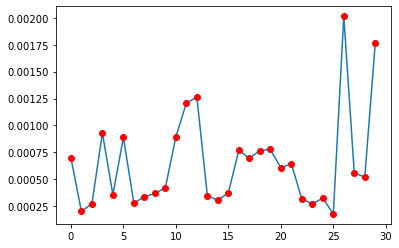

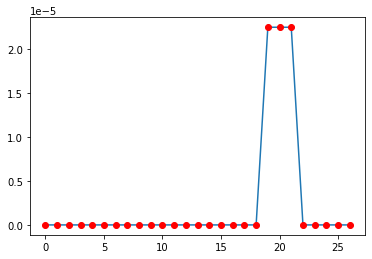

In [22]:
def CheckNormSize(norm_list):
    plt.plot(norm_list)
    plt.plot(norm_list, 'ro')
    plt.show()
CheckNormSize(Huzzi_norm)
CheckNormSize(oizi_norm)
# CheckNormSize(Nicname_norm)